# ***Brief Introduction***

In this notebook, we are trying to do semantic segmentation for self driving cars.

The [dataset](https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge) provides data images and labeled semantic segmentations captured via CARLA self-driving car simulator.

First let's import the dependencies

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D, concatenate, Activation, MaxPooling2D, UpSampling2D, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import matplotlib.pyplot as plt
import random
import os

# ***Data Preparation***

Because The data in our dataset is split across five folders, and for other reasons we will do some data preprcessing

In [2]:
# Create Lists of images and masks paths
path = '/kaggle/input/lyft-udacity-challenge/'
images_path = [path + 'data' + i + '/' + 'data' + i + '/' + 'CameraRGB' for i in ['A', 'B', 'C', 'D', 'E']]
masks_path = [path + 'data' + i + '/' + 'data' + i + '/' + 'CameraSeg' for i in ['A', 'B', 'C', 'D', 'E']]

In [3]:
# Defining a function that take the parent path and return a list of all images in that path
def return_paths(path):
    X = []
    for i in sorted(path):
        g = sorted(os.listdir(i))
        for j in g:
            X.append(i + '/' + j)
    return X

In [4]:
# Creating two lists of the images and masks pathes respectively.
X = return_paths(images_path)
Y = return_paths(masks_path)

# ***Splitting the data***

Now that we have two lists containing all the images and masks we have, We are ready to split our data into training, validation and test sets.

In [5]:
# Splitting the data into train, validation and test sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size = 0.2)

# ***Custom Data Generators***

Now that we have prepared and splitted our data, we need to define our Generators that are responsible for loading batches of the data and feed them to the model.
Before this step, we will need to defind a function that will be reponsible for loading, and resizing images

In [6]:
# This function will load and resize images and return arrays to the generators
def read_imageMask(image_path, mask_path):
    
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (256, 256), method='nearest')
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (256, 256), method='nearest')
    
    return img, mask

In [7]:
# Defining our custom generator
def data_generator(image_paths, mask_paths, batch_size):
    images = tf.constant(image_paths)
    masks = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.map(read_imageMask, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.cache().shuffle(500).batch(batch_size)
    
    return dataset

In [8]:
# Now we are ready to create the train, validation and test generators
train_generator = data_generator(X_train, Y_train, 32)
val_generator = data_generator(X_val, Y_val, 32)
test_generator = data_generator(X_test, Y_test, 32)

# ***Model***

Now that we have reached this point, Let's define our model.

For this Task We will use the U-net architecture

In [9]:
def unet(num_classes = 13, image_shape = (256, 256, 3)):
    # Input
    inputs = Input(image_shape)
    # Encoder Path
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D((2,2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder Path
    up6 = Conv2D(512, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([up6, conv4], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([up7, conv3], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([up8, conv2], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([up9, conv1], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    
    conv10 = Conv2D(num_classes, (1, 1), padding='same', activation='softmax')(conv9)
    
    model = Model(inputs, conv10)
    
    return model

In [10]:
# Create The Model
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

# ***Compling and Training***

In [11]:
# Complile The Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the Callbacks we will use during training
earlystopping = EarlyStopping(monitor='val_loss', patience= 20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)

In [12]:
# Train the Model
history = model.fit(train_generator, validation_data=val_generator,epochs=25,
                    verbose = 1, batch_size=16,
                    callbacks=[earlystopping, reduce_lr])

Epoch 1/25
125/125 [==============================] - 226s 2s/step - loss: 1.3466 - accuracy: 0.5967 - val_loss: 0.5591 - val_accuracy: 0.8278 - lr: 0.0010
Epoch 2/25
125/125 [==============================] - 136s 1s/step - loss: 0.3738 - accuracy: 0.8840 - val_loss: 0.2994 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 3/25
125/125 [==============================] - 136s 1s/step - loss: 0.2241 - accuracy: 0.9301 - val_loss: 0.1979 - val_accuracy: 0.9387 - lr: 0.0010
Epoch 4/25
125/125 [==============================] - 136s 1s/step - loss: 0.1646 - accuracy: 0.9479 - val_loss: 0.1483 - val_accuracy: 0.9528 - lr: 0.0010
Epoch 5/25
125/125 [==============================] - 136s 1s/step - loss: 0.1441 - accuracy: 0.9542 - val_loss: 0.1410 - val_accuracy: 0.9553 - lr: 0.0010
Epoch 6/25
125/125 [==============================] - 136s 1s/step - loss: 0.1145 - accuracy: 0.9631 - val_loss: 0.1099 - val_accuracy: 0.9647 - lr: 0.0010
Epoch 7/25
125/125 [==============================] - 136s 1s/st

# ***Evaluation***

Let's Now Visualize the Results

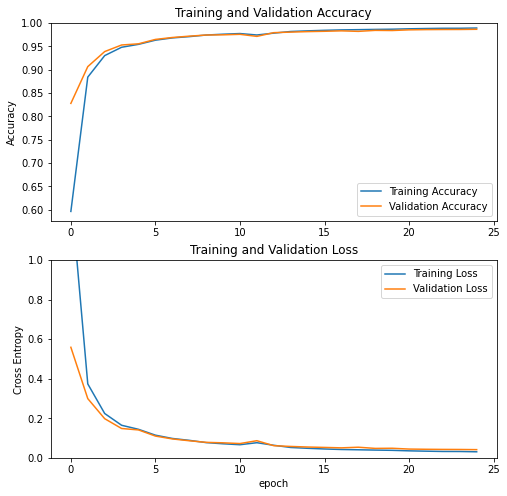

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluate The Model

In [14]:
train_loss, train_accuracy = model.evaluate(train_generator, batch_size = 32)
validation_loss, validation_accuracy = model.evaluate(val_generator, batch_size = 32)
test_loss, test_accuracy = model.evaluate(test_generator, batch_size = 32)

7/7 [==============================] - 3s 376ms/step - loss: 0.0380 - accuracy: 0.9868


Visualize The results of our Model on test data

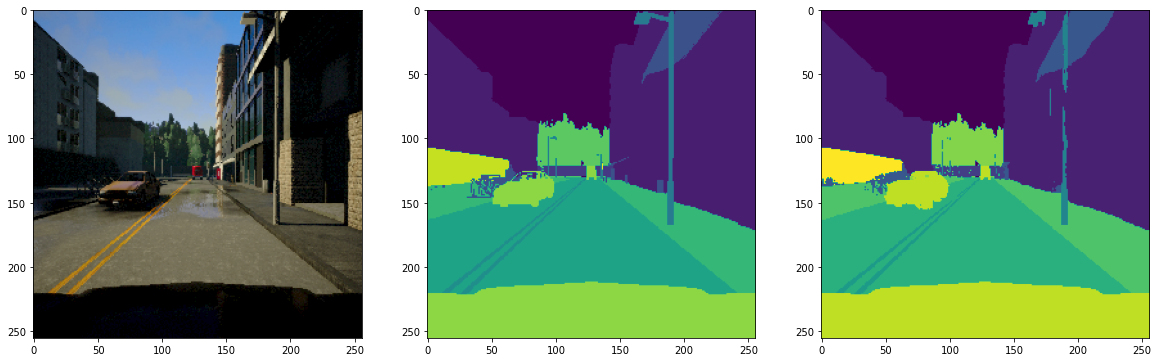

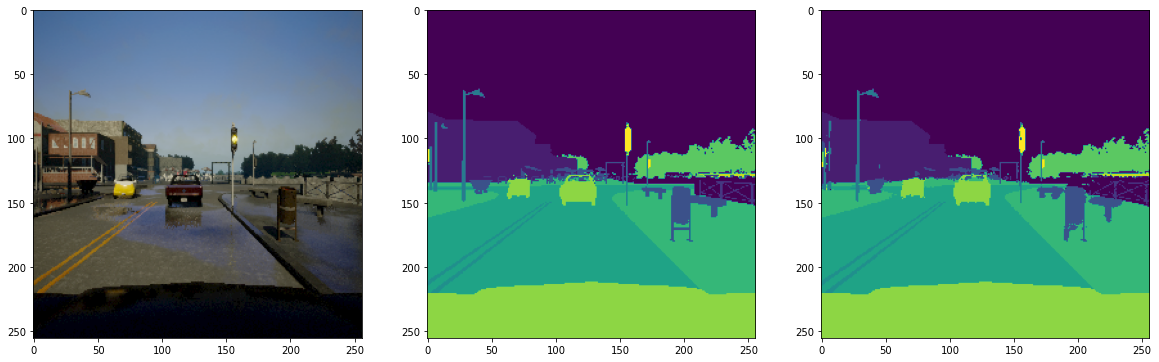

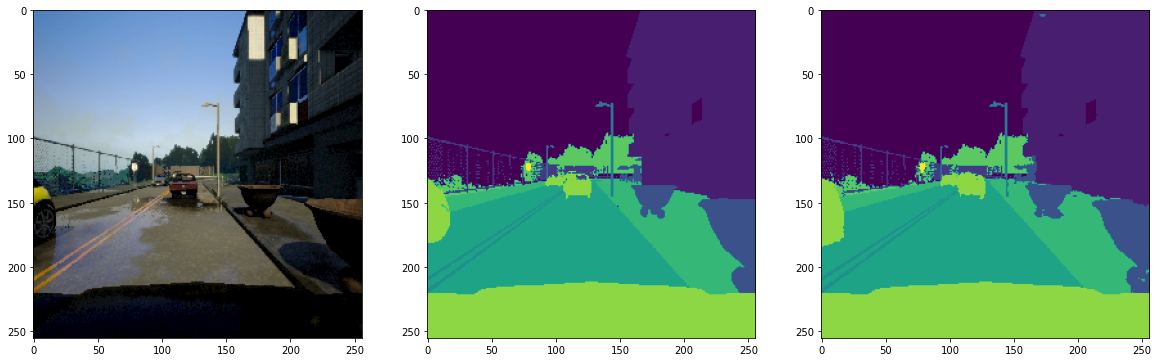

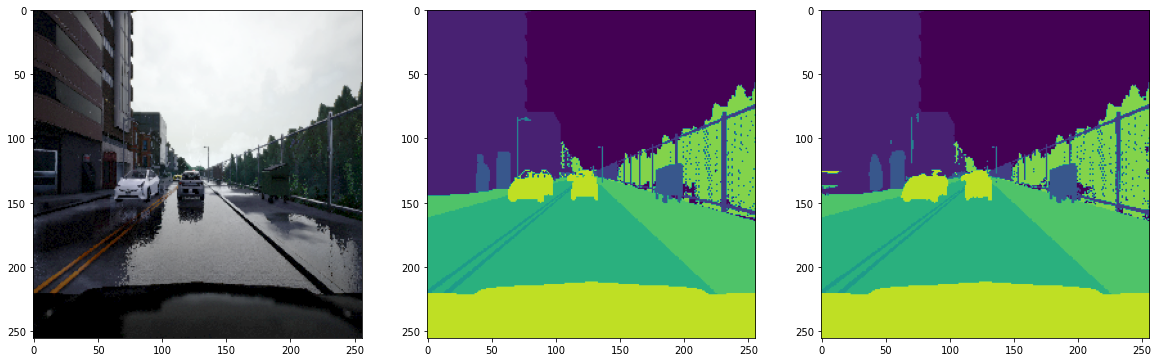

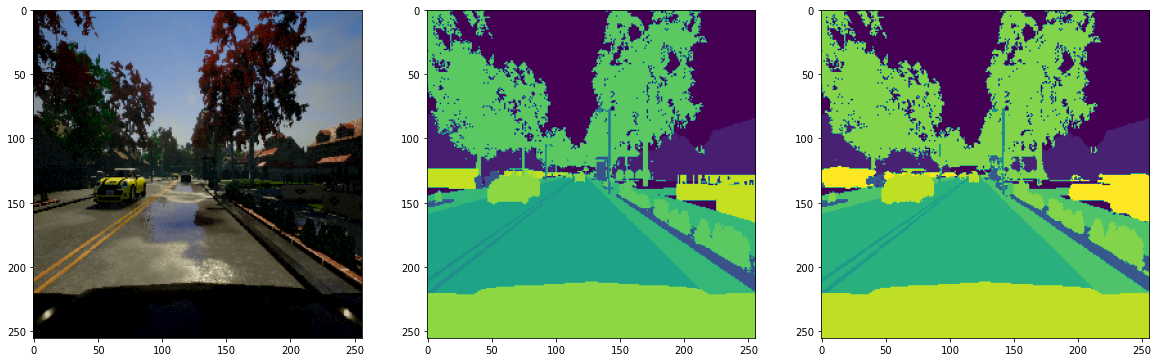

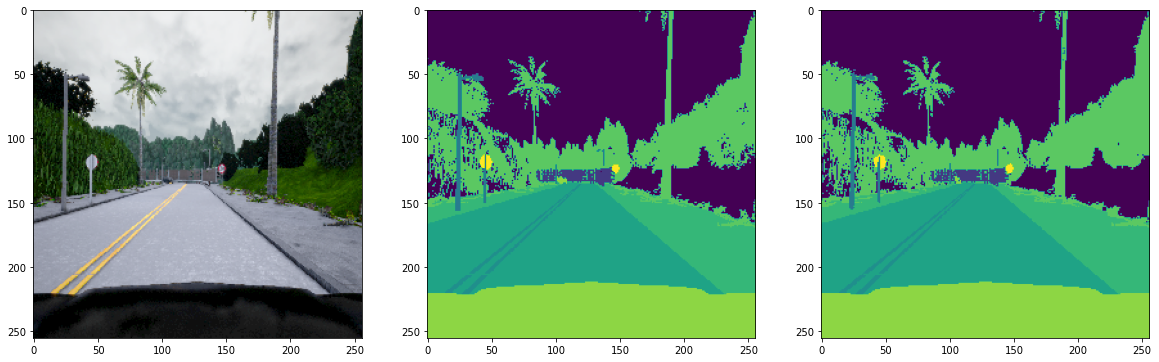

In [15]:
for image, mask in test_generator.take(6):
    pred_mask = model.predict(image)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))
    plt.subplot(1, 3, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))
    plt.subplot(1, 3, 3)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(tf.expand_dims(tf.argmax(pred_mask[0], axis = -1), axis = -1)))